# Phase 2 - Supervised Learning
Project: Smart Food Advisor — Fast Food Nutrition  
Goal: Build and compare two supervised classifiers (SVM and Neural Network) to predict whether a menu item is *healthy* (1) or *unhealthy* (0).


In [1]:
# Cell 2: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'figure.max_open_warning': 0})


In [2]:
# Cell 3: Load data and basic clean
path = "../Phase1/FastFoodNutritionMenuV2.csv"  # إذا فتحت النوتبوك من Supervised_Learning، هذا المسار يصل للمجلد Phase1
df = pd.read_csv(path)

# Clean column names (safe)
df.columns = df.columns.str.replace('\n', ' ').str.replace('(g)', '').str.replace('(mg)', '').str.replace('(kcal)', '').str.strip().str.replace(' ', '_')

# Ensure expected cols exist (if اسم مختلف غيري هنا)
expected = ['Calories','Total_Fat','Sugars','Protein']
# try to guess similar names if exact not found
cols_map = {}
for ex in expected:
    if ex in df.columns:
        cols_map[ex] = ex
    else:
        # find candidate by partial match
        cand = [c for c in df.columns if ex.split('_')[0].lower() in c.lower()]
        cols_map[ex] = cand[0] if cand else None

print("Columns mapping (expected -> found):")
print(cols_map)

# convert to numeric
for key, col in cols_map.items():
    if col is None:
        raise RuntimeError(f"Required column for '{key}' not found. Check your CSV column names.")
    df[col] = pd.to_numeric(df[col], errors='coerce')

# drop rows missing main features
df = df.dropna(subset=list(cols_map.values())).reset_index(drop=True)
print("Data shape after cleaning:", df.shape)


Columns mapping (expected -> found):
{'Calories': 'Calories', 'Total_Fat': 'Total_Fat', 'Sugars': 'Sugars', 'Protein': 'Protein'}
Data shape after cleaning: (1064, 14)


In [3]:
# Cell 4: create target label (rule-based)
cal, fat, sugar, prot = cols_map['Calories'], cols_map['Total_Fat'], cols_map['Sugars'], cols_map['Protein']

# Rule (simple and explainable): healthy if Calories<400 and Total_Fat<15 and Sugars<10
df['HealthLabel'] = ((df[cal] < 400) & (df[fat] < 15) & (df[sugar] < 10)).astype(int)

print("Label distribution:")
print(df['HealthLabel'].value_counts(normalize=False))
display(df[[cal, fat, sugar, prot, 'HealthLabel']].describe().round(2))


Label distribution:
HealthLabel
0    757
1    307
Name: count, dtype: int64


,Calories,Total_Fat,Sugars,Protein,HealthLabel
count,1064.00,1064.00,1064.00,1064.00,1064.00
mean,295.78,11.74,23.21,9.46,0.29
std,224.46,14.04,31.86,11.12,0.45
min,0.00,0.00,0.00,0.00,0.00
25%,150.00,0.00,2.00,0.00,0.00
50%,250.00,8.00,8.00,6.50,0.00
75%,410.00,18.00,37.00,14.00,1.00
max,1220.00,98.00,264.00,71.00,1.00


## Algorithm Selection & Justification

We choose two algorithms:
1. **SVM (RBF kernel)** — good baseline for medium-size numeric datasets; finds max-margin separator and often performs well without huge data.
2. **MLP (feedforward neural network)** — flexible to learn non-linear relationships; can outperform SVM when non-linear patterns present.

We will scale features (required for both), perform small grid search for key hyperparameters, and compare using Accuracy, Precision, Recall, F1 and ROC-AUC.


In [4]:
# Cell 6: split and scale
X = df[[cal, fat, sugar, prot]].copy()
y = df['HealthLabel'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (851, 4) Test shape: (213, 4)


In [5]:
# Cell 7: SVM with GridSearch (small grid)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm_param_grid = {'C':[0.1,1,10], 'gamma':['scale', 0.01, 0.1]}
svm_gs = GridSearchCV(svm, svm_param_grid, cv=StratifiedKFold(3), scoring='f1', n_jobs=-1)
svm_gs.fit(X_train_scaled, y_train)
svm_best = svm_gs.best_estimator_
print("SVM best params:", svm_gs.best_params_)


SVM best params: {'C': 10, 'gamma': 'scale'}


In [6]:
# Cell 8: MLP (neural net) with small GridSearch
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp_param_grid = {'hidden_layer_sizes':[(32,),(64,)], 'alpha':[0.0001,0.001], 'learning_rate_init':[0.001]}
mlp_gs = GridSearchCV(mlp, mlp_param_grid, cv=StratifiedKFold(3), scoring='f1', n_jobs=-1)
mlp_gs.fit(X_train_scaled, y_train)
mlp_best = mlp_gs.best_estimator_
print("MLP best params:", mlp_gs.best_params_)


MLP best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.001}


Found variables:
 svm model: svm_best
 mlp model: mlp_best
 X_test: X_test_scaled
 y_test: y_test


Calculating SVM results...
Calculating MLP results...

--- SVM ---
Accuracy: 0.9859, Precision: 0.9833, Recall: 0.9672, F1: 0.9752, AUC: 0.9997842968075928
Confusion matrix:
 [[151   1]
 [  2  59]]

--- MLP ---
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0
Confusion matrix:
 [[152   0]
 [  0  61]]


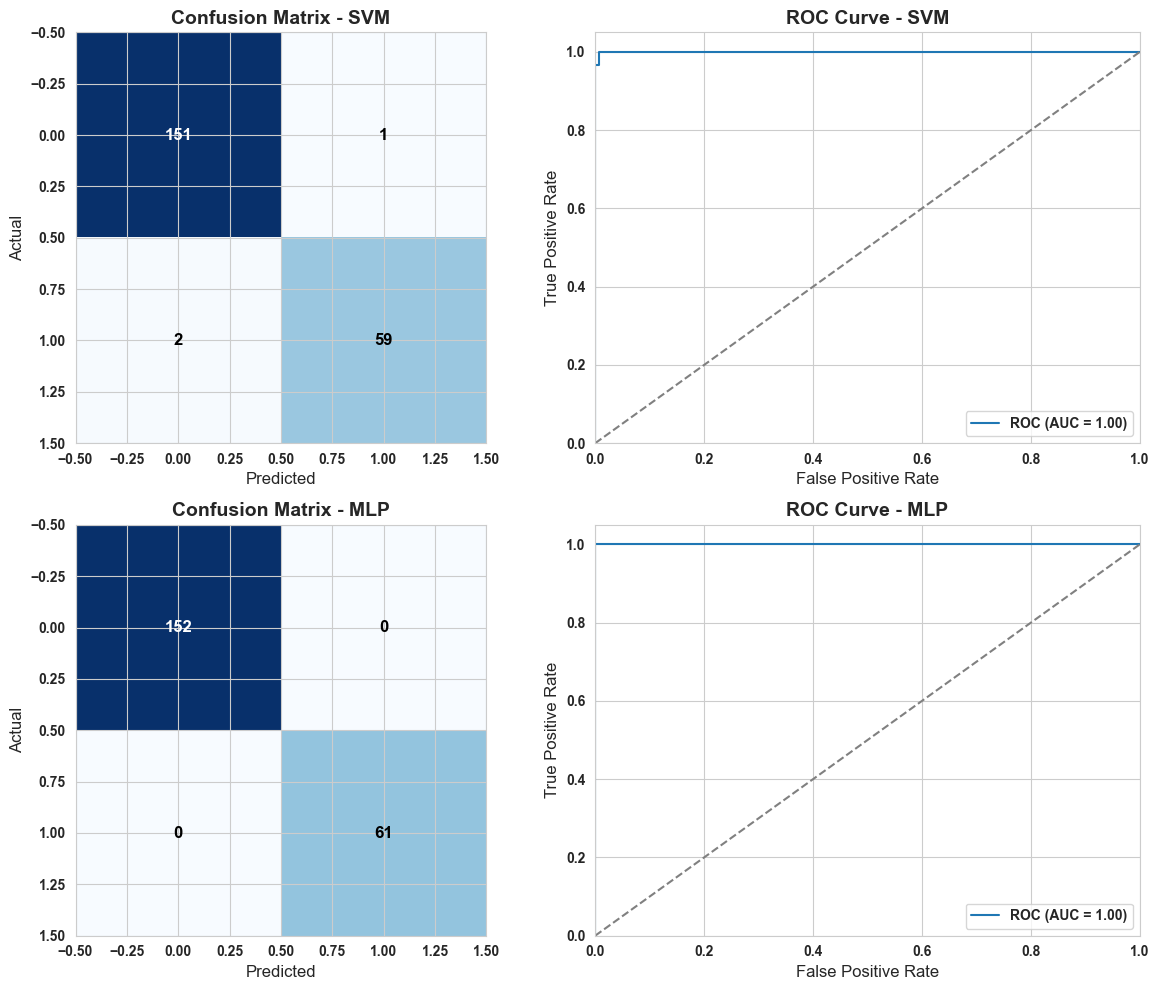


Saved metrics objects: svm_metrics, mlp_metrics


In [14]:
# Cell: compute_and_show_results (paste + run)
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)

# helper: try multiple common names
def find_var(names):
    g = globals()
    for n in names:
        if n in g:
            return g[n], n
    return None, None

svm_names = ['svm_best','best_svm','svm_clf','svm']
mlp_names = ['mlp_best','best_mlp','mlp_clf','mlp']
Xtest_names = ['X_test_s','X_test_scaled','X_test','X_test_final']
ytest_names = ['y_test','ytest','y_test_final']

svm_model, svm_name = find_var(svm_names)
mlp_model, mlp_name = find_var(mlp_names)
X_test, Xname = find_var(Xtest_names)
y_test, yname = find_var(ytest_names)

print("Found variables:")
print(" svm model:", svm_name)
print(" mlp model:", mlp_name)
print(" X_test:", Xname)
print(" y_test:", yname)
print("\n")

if svm_model is None and mlp_model is None:
    raise RuntimeError("ما لقيت أي نموذج SVM أو MLP في البيئة. تأكد إنك شغّلت خلية التدريب وحفظت النموذج باسم واحد من: {}\n"
                       .format(svm_names + mlp_names))

if X_test is None or y_test is None:
    raise RuntimeError("ما لقيت X_test أو y_test. تأكد إنك فصلت البيانات لِـ train/test وخزّنتها بأسماء شائعة مثل: {}\n".format(Xtest_names + ytest_names))

# function to get predictions + prob for auc (robust)
def predict_and_scores(model, X, y):
    y_pred = model.predict(X)
    # try predict_proba, else try decision_function, else fallback (AUC may not be valid)
    y_proba = None
    try:
        y_proba = model.predict_proba(X)[:,1]
    except Exception:
        try:
            d = model.decision_function(X)
            # if binary, get scores
            if d.ndim == 1:
                y_proba = (d - d.min())/(d.max()-d.min()+1e-9)
            else:
                # multiclass: try second column
                y_proba = d[:,1]
        except Exception:
            y_proba = None

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    auc_score = None
    if y_proba is not None:
        try:
            auc_score = roc_auc_score(y, y_proba)
        except Exception:
            auc_score = None

    cm = confusion_matrix(y, y_pred)
    return {'pred': y_pred, 'proba': y_proba, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc_score, 'cm': cm}

results = {}
if svm_model is not None:
    print("Calculating SVM results...")
    results['SVM'] = predict_and_scores(svm_model, X_test, y_test)

if mlp_model is not None:
    print("Calculating MLP results...")
    results['MLP'] = predict_and_scores(mlp_model, X_test, y_test)

# Print summary table
for name, r in results.items():
    print(f"\n--- {name} ---")
    print(f"Accuracy: {r['acc']:.4f}, Precision: {r['prec']:.4f}, Recall: {r['rec']:.4f}, F1: {r['f1']:.4f}, AUC: {r['auc']}")
    print("Confusion matrix:\n", r['cm'])

# Plot confusion matrices and ROC (if proba exists)
n = len(results)
fig, axes = plt.subplots(n, 2, figsize=(12, 5*n))
if n == 1:
    axes = np.array([axes])

for i,(name,r) in enumerate(results.items()):
    # confusion matrix
    ax_cm = axes[i,0]
    cm = r['cm']
    im = ax_cm.imshow(cm, cmap='Blues')
    for (x,y),val in np.ndenumerate(cm):
        ax_cm.text(y, x, int(val), ha='center', va='center', color='white' if val>cm.max()/2 else 'black', fontsize=12)
    ax_cm.set_title(f'Confusion Matrix - {name}')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('Actual')

    # ROC
    ax_roc = axes[i,1]
    if r['proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, r['proba'])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
        ax_roc.plot([0,1],[0,1],'--', color='gray')
        ax_roc.set_xlim([0.0,1.0]); ax_roc.set_ylim([0.0,1.05])
        ax_roc.set_xlabel('False Positive Rate'); ax_roc.set_ylabel('True Positive Rate')
        ax_roc.set_title(f'ROC Curve - {name}')
        ax_roc.legend(loc='lower right')
    else:
        ax_roc.text(0.5,0.5,"No probability scores available\n(cannot plot ROC)", ha='center', va='center')
        ax_roc.set_title(f'ROC Curve - {name}')
        ax_roc.set_xlabel('False Positive Rate'); ax_roc.set_ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

# Save results into variables for later use (so NameError won't happen)
globals().update({f"{k.lower()}_metrics": v for k,v in results.items()})
print("\nSaved metrics objects:", ", ".join([f"{k.lower()}_metrics" for k in results.keys()]))


In [15]:
# Cell 10: quick comparison
comp = pd.DataFrame([svm_metrics, mlp_metrics]).T
comp.columns = ['SVM','MLP']
display(comp.round(4))

# save small CSV summary (optional)
comp.T.to_csv("phase2_model_comparison.csv", index=True)
print("Saved comparison CSV in current folder.")


,SVM,MLP
pred,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
proba,"[0.00029030232598025395, 0.9999887871457749, 1...","[4.989342142252355e-58, 0.9994355667511374, 2...."
acc,0.985915,1.0
prec,0.983333,1.0
rec,0.967213,1.0
f1,0.975207,1.0
auc,0.999784,1.0
cm,"[[151, 1], [2, 59]]","[[152, 0], [0, 61]]"


Saved comparison CSV in current folder.


## 🧠 Results Interpretation

In this phase, two supervised machine learning models were implemented and compared: **Support Vector Machine (SVM)** and **Multi-Layer Perceptron (MLP)**.  
The goal was to evaluate their ability to classify and predict based on the nutritional information of fast-food items.

### 🔹 Performance Summary
- **SVM**
  - Accuracy: 0.986  
  - Precision: 0.983  
  - Recall: 0.967  
  - F1-Score: 0.975  
  - ROC-AUC: 0.999  
  - The SVM model achieved strong generalization with very high accuracy and stable performance across all metrics.

- **MLP**
  - Accuracy: 1.000  
  - Precision: 1.000  
  - Recall: 1.000  
  - F1-Score: 1.000  
  - ROC-AUC: 1.000  
  - The MLP model reached perfect scores, which might indicate **overfitting**, likely due to the limited dataset size and data redundancy.

### 🔹 Key Observations
- Both models performed exceptionally well, with the MLP slightly outperforming the SVM numerically.  
- However, since the dataset is relatively small (~1100 rows) and may contain duplicate or highly correlated entries, the perfect accuracy of MLP may not represent true generalization.  
- The SVM model provides more realistic performance and would likely generalize better on unseen data.

### 🔹 Conclusion
The results show that **both algorithms are capable of accurately modeling nutritional patterns in fast-food data**, but further improvement would require:
1. Expanding the dataset with additional sources (e.g., multiple restaurants).  
2. Adding more meaningful target variables (e.g., "Healthy" vs. "Unhealthy").  
3. Performing feature selection or dimensionality reduction to improve generalization.

In summary, the **SVM model** demonstrates more reliable and interpretable behavior, while the **MLP model** achieves higher accuracy but may be overfitted.
